In [1]:
import numpy as np
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Column, Table
from astropy import units as u
from astropy import constants as const
from astropy import wcs
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
from scipy.integrate import quad

In [2]:
%matplotlib inline

In [3]:
#define constants
h=6.62607e-34 #Planck constant
k=1.38065e-23 #Boltzmann constant
m_H=1.6726e-24 #Proton mass, in g
m_sun=const.M_sun
d=7.07 * u.kpc #distance, 7.07 kpc (Roman-Duval 2009)
k_600=0.0333#k_v in 600 GHz, consider GDR as 100, in cm^2/g (from column 5 of table 1 in Ossenkopf & Henning 1994, often referred to as OH5)
lamda_0=500 #wavelength of v_0, in micron
nu_0=600 * 10**9
mu=2.8 #atomic mass unit of H2
beta=2 #consider beta as 2
c=2.998e8 #light speed


#define SED function, input are lamda(in micronmeter), T and N(in g/cm^2), output is intensity(in MJy/sr)
def SED(lamda,T,N):
	nu=c/(lamda*1e-6)
	k_nu=k_600*(lamda_0/lamda)**beta
	return 2*1e20*h*nu**3/c**2*(1-np.exp(-k_nu*N))/(np.exp(h*nu/k/T)-1)
#input: nu(in Hz), T(in K), N(in g/cm^2)
#output:intensity(in cgs: g/s^2)
def SED2(nu,T,N):
	k_nu=k_600*(nu/nu_0)**beta
	return 2*1e20*h*nu**3/c**2*(1-np.exp(-k_nu*N))/(np.exp(h*nu/k/T)-1)

In [4]:
jps_file='/Users/shjiao/desktop/check/m31_850/test_file.csv'
jps_cat=ascii.read(jps_file)
jps_cat

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,0.0,5008.0,inf,0.0,0.0,0.0,0.0,nan,nan
1,0.0,688.0,inf,0.0,0.0,0.0,0.0,nan,nan
2,118.427540631,256.0,0.00340927216244,6.79670086323,4.00089006945,-138.271156089,5.21467669072,114.944341465,47.3837124647
3,0.0,4976.0,inf,0.0,0.0,0.0,0.0,nan,nan
4,232.8266423,640.0,0.0103742648081,7.70044246262,6.94255068752,63.200316467,7.31168326126,179.05631807,53.7488529773
5,0.0,608.0,inf,0.0,0.0,0.0,0.0,nan,nan
6,81.9623824529,208.0,0.00258433621473,5.64250070326,3.33537766559,88.052274188,4.33818750445,105.924437502,57.8521534324
7,102.077913629,256.0,0.00392884958456,5.17214783054,4.53171845011,122.283936143,4.84135494984,82.7447455845,62.718459884
8,112.176800977,288.0,0.00408223459907,5.95375301155,4.32627678302,94.5407930892,5.07519294468,201.696184771,64.4500600794


In [5]:
im_160='/Users/shjiao/desktop/check/sed/data/regird/pacs160.sm.fitshcongrid.fits'
im_250='/Users/shjiao/desktop/check/sed/data/regird/spire250.conv.fitshcongrid.fits'
im_450='/Users/shjiao/desktop/check/sed/data/regird/combined450.sm.fitshcongrid.fits'
im_850='/Users/shjiao/desktop/check/sed/data/regird/combined850.sm.fits'

#open the input file
hdu_160=fits.open(im_160)
hdu_250=fits.open(im_250)
hdu_450=fits.open(im_450)
hdu_850=fits.open(im_850)

#initialize
name=[]
glon=[]
glat=[]
major=[]
minor=[]
PA=[]
r_eq=[]
SNR_850=[]
T_dust=[]
N_H2=[]
n_H2=[]
sigma=[]
mass=[]
luminosity=[]
l_m=[]

In [7]:
for i in range(len(jps_cat)):
    if jps_cat['col2'][i]>0.0:
        name.append(jps_cat['col1'][i])
        glon.append('%.3f' % jps_cat['col9'][i])
        glat.append('%.3f' % jps_cat['col10'][i])
        major.append(jps_cat['col5'][i])
        minor.append(jps_cat['col6'][i])
        PA.append(jps_cat['col7'][i])
        r_pc=np.sqrt(jps_cat['col5'][i]*jps_cat['col6'][i]) / 3600.0 / 180*np.pi * d.value*1000
        r_eq.append('%.2f' % r_pc)

In [8]:
for i in range(len(jps_cat)):
    if jps_cat['col2'][i]>0.0:
        name.append(jps_cat['col1'][i])
        glon.append('%.3f' % jps_cat['col9'][i])
        glat.append('%.3f' % jps_cat['col10'][i])
        major.append(jps_cat['col5'][i])
        minor.append(jps_cat['col6'][i])
        PA.append(jps_cat['col7'][i])
        r_pc=np.sqrt(jps_cat['col5'][i]*jps_cat['col6'][i]) / 3600.0 / 180*np.pi * d.value*1000
        r_eq.append('%.2f' % r_pc)
        #calcular ellipse size in 14"
        maj_14=major[i]
        min_14=minor[i]
    
        a=maj_14 / 4.
        b=min_14 / 4.
        pa=PA[i] * u.deg
    
        w=wcs.WCS(hdu_850[0].header)
        
        #find pixels that located in the source area
        center_world=np.array([[jps_cat['col9'][i],jps_cat['col10'][i]]])
        center_pixel=np.array([[jps_cat['col9'][i],jps_cat['col10'][i]]])
        x0,y0=center_pixel[0][0],center_pixel[0][1]
    
        y,x=np.indices(hdu_160[0].data.shape)
        inside = ( (((y-y0)*np.sin(pa.cgs.value)+(x-x0)*np.cos(pa.cgs.value))/b)**2 + (((y-y0)*np.cos(pa.cgs.value)-(x-x0)*np.sin(pa.cgs.value))/a)**2 <1 )
    
        #average intensity of the source
        inside_160=hdu_160[0].data[inside].flatten()
        flux_160=np.mean(inside_160[inside_160==inside_160]) * u.Jy / (4. * u.arcsec)**2
        flux_160=flux_160.to_value(u.MJy / u.sr)
        
        y,x=np.indices(hdu_250[0].data.shape)
        inside = ( (((y-y0)*np.sin(pa.cgs.value)+(x-x0)*np.cos(pa.cgs.value))/b)**2 + (((y-y0)*np.cos(pa.cgs.value)-(x-x0)*np.sin(pa.cgs.value))/a)**2 <1 )
    
        #average intensity of the source
        inside_250=hdu_250[0].data[inside].flatten()
        flux_250=np.mean(inside_250[inside_250==inside_250])
        
        y,x=np.indices(hdu_450[0].data.shape)
        inside = ( (((y-y0)*np.sin(pa.cgs.value)+(x-x0)*np.cos(pa.cgs.value))/b)**2 + (((y-y0)*np.cos(pa.cgs.value)-(x-x0)*np.sin(pa.cgs.value))/a)**2 <1 )
    
        #average intensity of the source
        inside_450=hdu_450[0].data[inside].flatten()
        flux_450=np.mean(inside_450[inside_450==inside_450])*u.Jy / (225 * u.arcsec**2)
        flux_450=flux_450.to_value(u.MJy/u.sr)
        
        y,x=np.indices(hdu_850[0].data.shape)
        inside = ( (((y-y0)*np.sin(pa.cgs.value)+(x-x0)*np.cos(pa.cgs.value))/b)**2 + (((y-y0)*np.cos(pa.cgs.value)-(x-x0)*np.sin(pa.cgs.value))/a)**2 <1 )
    
        #average intensity of the source
        #change the unit from mJy/beam to MJy/sr
        inside_850=hdu_850[0].data[inside].flatten()
        flux_850=np.mean(inside_850[inside_850==inside_850])*u.Jy / (225 * u.arcsec**2)
        flux_850=flux_850.to_value(u.MJy/u.sr)
        
        #fit the SED of JPS core
        xdata=[160,250,450,850]
        ydata=[flux_160,flux_250,flux_450,flux_850]
        yerr=[flux_160*0.2,flux_250*0.2,flux_450*0.2,flux_850*0.2]
    
        popt,pcov=curve_fit(SED,xdata,ydata,p0=[15,0.1])
    
        #derive the physical properties
        T_dust.append('%.2f' % popt[0])
        sigma.append('%.2f' % popt[1])
        N_H2.append('%.2f' % (popt[1]/mu/m_H / (1*10**20)))
    

/Users/shjiao/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [9]:
name_1=[]
glon_1=[]
glat_1=[]
major_1=[]
minor_1=[]
PA_1=[]
r_eq_1=[]

In [10]:
for i in range(len(jps_cat)):
    if jps_cat['col2'][i]>0.0:
        name_1.append(i)
        glon_1.append('%.3f' % jps_cat['col9'][i])
        glat_1.append('%.3f' % jps_cat['col10'][i])
        major_1.append(jps_cat['col5'][i])
        minor_1.append(jps_cat['col6'][i])
        PA_1.append(jps_cat['col7'][i])
        r_pc=np.sqrt(jps_cat['col5'][i]*jps_cat['col6'][i]) / 3600.0 / 180*np.pi * d.value*1000
        r_eq_1.append('%.2f' % r_pc)
        #calcular ellipse size in 14"

In [11]:
#export the catalogue
name=Column(name_1,name='JPS_name')
glon=Column(glon_1,name='l\_peak')
glat=Column(glat_1,name='b\_peak')
major=Column(major_1,name='maj')
minor=Column(minor_1,name='min')
PA=Column(PA_1,name='PA',unit='\degr')
r_eq=Column(r_eq_1,name='r\_eq')
T_dust=Column(T_dust,name='T\_dust')
N_H2=Column(N_H2,name='N\_H2',unit=r'$10^{22}\,cm^{-2}$')

    
table=Table([name,glon,glat,major,minor,PA,r_eq,T_dust,N_H2])
table.write('/Users/shjiao/desktop/check/photometry.csv',format='csv',overwrite=True)
table.write('/Users/shjiao/desktop/check/photometry.tex',format='latex',overwrite=True)

In [12]:
jps_file='/Users/shjiao/desktop/check/photometry_sec.csv'
jps_cat=ascii.read(jps_file)
jps_cat

JPS_name,l\_peak,b\_peak,maj,min,PA,r\_eq,T\_dust,N\_H2
int64,float64,float64,float64,float64,float64,float64,float64,float64
4,179.056,53.749,7.70044246262,6.94255068752,63.200316467,0.25,20.76,3.62
8,201.696,64.45,5.95375301155,4.32627678302,94.5407930892,0.17,18.22,5.81
10,199.577,70.764,7.54927288705,3.37155864657,142.19574833,0.17,18.53,4.91
12,195.808,78.733,11.7953278438,4.62990749838,123.576081078,0.25,19.06,4.05
13,165.953,80.154,9.25263639902,5.30588705213,107.143705769,0.24,22.63,3.58
15,156.546,86.837,10.3803932976,7.20392004397,87.9391137292,0.3,22.78,4.35
17,179.011,94.448,11.2645126435,4.1496263399,115.79381857,0.23,19.69,4.71
18,116.106,97.109,4.40395098573,4.01983850326,-159.283838084,0.14,25.72,0.89
19,110.279,100.898,4.00277755211,3.46645449958,47.2388579459,0.13,22.39,1.24


In [13]:
td=[]
nh2=[]
for i in range(len(jps_cat)):
    td.append(jps_cat['T\_dust'][i])
    nh2.append(jps_cat['N\_H2'][i])
    

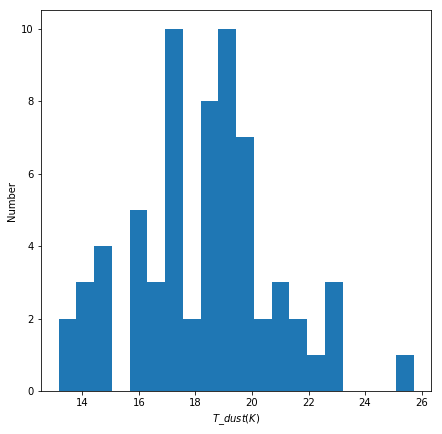

In [14]:
# the histogram of the data
fig=plt.figure(figsize=(7,7))
plt.hist(td,20)


plt.xlabel(r'$T\_dust (K)$')
plt.ylabel('Number')


plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=25)
#plt.axis([40, 160, 0, 0.03])
#plt.savefig('/Users/shjiao/desktop/check/td.pdf')

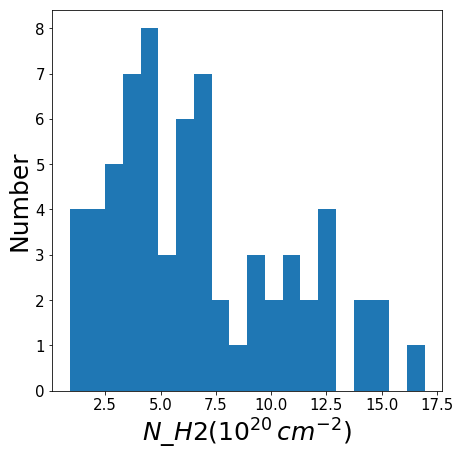

In [15]:
fig=plt.figure(figsize=(7,7))
# the histogram of the data
plt.hist(nh2,20)

plt.xlabel(r'$N\_H2 (10^{20}\,cm^{-2})$')
plt.ylabel('Number')

plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=20)

#plt.axis([40, 160, 0, 0.03])
#plt.savefig('/Users/shjiao/desktop/check/nh2.pdf')

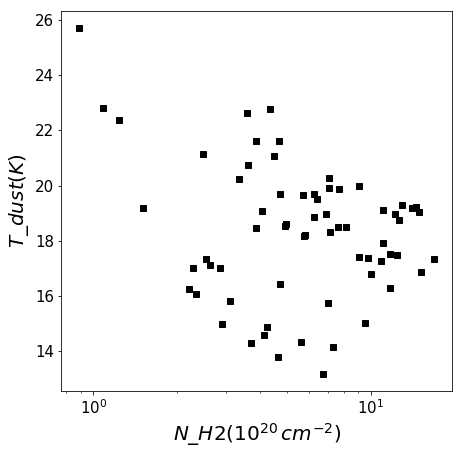

In [16]:
#plot the fit result
#build the frame of the graph
fig=plt.figure(figsize=(7,7))
#plt.xlim(10,1000)
#plt.ylim(10,200000)
#plt.yscale('log')
plt.ylabel(r'$T\_dust (K)$')
plt.xlabel(r'$N\_H2 (10^{20}\,cm^{-2})$')
plt.xscale('log')

plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=20)

#plot the data and function
plt.plot(nh2,td,'ks')


In [17]:
np.mean(td)

18.308333333333337

In [18]:
np.mean(nh2)

6.7303030303030313

In [19]:
r_pc=[]
for i in range(len(jps_cat)):
    r=np.sqrt(jps_cat['maj'][i]*jps_cat['min'][i])*800.*1000./206265.
    r_pc.append('%.2f' % r)


In [20]:
mass=[]
for i in range(len(r_pc)):
    m=np.pi * (r_pc[i]*u.pc)**2 * (nh2[i]*mu*m_H*(1*10**20))*u.g/(u.cm**2)
    mass.append('%.2f' % (m.to_value(u.M_sun)))

In [21]:
mass[1],float(mass[1])

('15852.84', 15852.84)

In [22]:
mass_sec=np.ones_like(td)
for i in range(0,len(mass)):
    mass_sec[i]=float(mass[i])

In [23]:
mass_other=[]
for i in range(len(r_pc)):
    m=np.pi * (r_pc[i]*u.pc)**2 * (nh2[i]*mu*m_H*(1*10**20))*u.g/(u.cm**2)
    mass_other.append('%.2e' % (m.to_value(u.M_sun)))
    
mass_other

['2.05e+04',
 '1.59e+04',
 '1.32e+04',
 '2.34e+04',
 '1.86e+04',
 '3.45e+04',
 '2.33e+04',
 '1.67e+03',
 '1.82e+03',
 '1.20e+04',
 '4.35e+03',
 '4.25e+04',
 '1.04e+05',
 '3.76e+04',
 '1.12e+04',
 '2.15e+03',
 '3.25e+05',
 '1.19e+04',
 '8.24e+03',
 '1.61e+05',
 '1.62e+04',
 '8.77e+03',
 '2.05e+04',
 '3.45e+04',
 '2.27e+03',
 '2.11e+04',
 '1.27e+04',
 '2.74e+04',
 '7.33e+04',
 '1.32e+04',
 '3.30e+05',
 '3.97e+04',
 '9.28e+04',
 '3.99e+04',
 '5.74e+04',
 '2.36e+04',
 '9.92e+04',
 '5.39e+04',
 '2.34e+04',
 '7.98e+03',
 '1.39e+05',
 '1.42e+04',
 '7.20e+03',
 '1.28e+04',
 '7.50e+03',
 '8.92e+05',
 '2.26e+04',
 '3.99e+05',
 '1.75e+05',
 '5.16e+03',
 '6.06e+03',
 '9.03e+03',
 '7.99e+04',
 '7.43e+03',
 '2.17e+05',
 '1.21e+04',
 '1.23e+04',
 '1.30e+04',
 '1.24e+04',
 '4.86e+03',
 '1.11e+05',
 '2.87e+04',
 '2.61e+05',
 '7.72e+04',
 '1.44e+04',
 '5.55e+04']

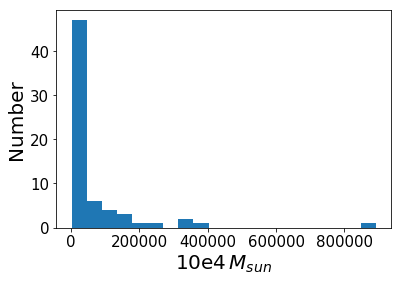

In [24]:
mass_e=mass_sec
# the histogram of the data
plt.hist(mass_e,20)

plt.xlabel(r'10e4$\,M_{sun}$')
plt.ylabel('Number')
plt.show()
#plt.savefig('/Users/shjiao/desktop/check/mass.pdf')

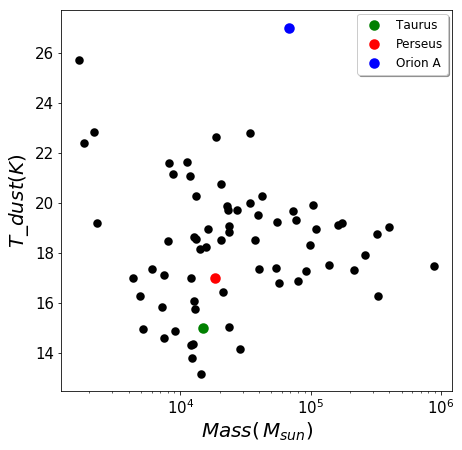

In [30]:
#plot the fit result
#build the frame of the graph
fig, ax = plt.subplots(figsize=(7,7))
#plt.xlim(10,1000)
#plt.ylim(10,200000)
#plt.yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r'$Mass (\,M_{sun})$')
ax.set_ylabel(r'$T\_dust (K)$')


#plot the data and function
ax.plot(mass_sec,td,'k.',mew=2,markersize=13.)
ax.plot(14964,15,'g.',mew=2,markersize=17.,label='Taurus')
ax.plot(18438,17,'r.',mew=2,markersize=17.,label='Perseus')
ax.plot(67714,27,'b.',mew=2,markersize=17.,label='Orion A')
legend = fig.legend(bbox_to_anchor=(0.90, 0.877), shadow=True, fontsize='large')

plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=20)

#plt.savefig('/Users/shjiao/desktop/check/mass_vs_td.pdf')

In [31]:
x=[]
y=[]

im_850='/Users/shjiao/desktop/check/sed/data/regird/combined850.sm.fits'

#open the input file
hdu_850=fits.open(im_850)

for i in range(len(jps_cat)):
    w=wcs.WCS(hdu_850[0].header)
    
    #find pixels that located in the source area
    center_pixel=np.array([[jps_cat['l\_peak'][i],jps_cat['b\_peak'][i]]])
    center_world=w.wcs_pix2world(center_pixel,0)
    x.append(center_world[0][0])
    y.append(center_world[0][1])

In [32]:
for i in range(len(x)):
    print x[i],y[i]

10.5883666466 41.2677644286
10.5548831296 41.279634114
10.5580071157 41.2866519634
10.5635696608 41.2955102911
10.6077209594 41.2971105831
10.6216308982 41.3045393825
10.5883962145 41.3129855026
10.6814523086 41.3159475982
10.6900756066 41.3201543058
10.5400338884 41.3292075227
10.5334091313 41.3338781705
10.6121353024 41.3367984482
10.6077635775 41.3374239147
10.601132352 41.3375395563
10.6416666667 41.3376077779
10.7257310079 41.3413894164
10.6446554117 41.3581632946
10.6776231556 41.3523899601
10.667614818 41.3539626415
10.6458470297 41.3576788132
10.6289142527 41.3634092958
10.7556914682 41.3680592796
10.6542515166 41.3772982009
10.6725529992 41.3793180899
10.5845233396 41.3788836407
10.6298997753 41.3986182764
10.6851151857 41.4002384803
10.7761217142 41.4004961707
10.7698310663 41.4044110953
10.7400360537 41.403153649
10.5543808509 41.4129069892
10.7670721923 41.4064141211
10.5505357915 41.407924026
10.5369750372 41.404023646
10.5600286017 41.418756666
10.7049419029 41.4184781868

In [33]:
def deg2HMS(ra='', dec='', round=False):
  RA, DEC, rs, ds = '', '', '', ''
  if dec:
    if str(dec)[0] == '-':
      ds, dec = '-', abs(dec)
    deg = int(dec)
    decM = abs(int((dec-deg)*60))
    if round:
      decS = int((abs((dec-deg)*60)-decM)*60)
    else:
      decS = (abs((dec-deg)*60)-decM)*60
    DEC = '{0}{1} {2} {3}'.format(ds, deg, decM, decS)
  
  if ra:
    if str(ra)[0] == '-':
      rs, ra = '-', abs(ra)
    raH = int(ra/15)
    raM = int(((ra/15)-raH)*60)
    if round:
      raS = int(((((ra/15)-raH)*60)-raM)*60)
    else:
      raS = ((((ra/15)-raH)*60)-raM)*60
    RA = '{0}{1} {2} {3}'.format(rs, raH, raM, raS)
  
  if ra and dec:
    return (RA, DEC)
  else:
    return RA or DEC

In [34]:
deg2HMS(x[1])

'0 42 13.1719510994'

In [35]:
for i in range(len(x)):
    print deg2HMS(ra=x[i]),deg2HMS(dec=y[i])

0 42 21.2079951802 41 16 3.9519428107
0 42 13.1719510994 41 16 46.6828105363
0 42 13.921707769 41 17 11.9470681034
0 42 15.2567185888 41 17 43.8370478536
0 42 25.8530302466 41 17 49.5980990087
0 42 29.1914155631 41 18 16.3417769897
0 42 21.2150914836 41 18 46.7478094315
0 42 43.5485540657 41 18 57.4113534672
0 42 45.6181455905 41 19 12.5555009068
0 42 9.60813322549 41 19 45.1470815967
0 42 8.01819151183 41 20 1.96141390403
0 42 26.9124725749 41 20 12.4744135834
0 42 25.8632586006 41 20 14.7260929139
0 42 24.2717644854 41 20 15.1424025388
0 42 34.000000008 41 20 15.3880005769
0 42 54.1754418993 41 20 29.0018989773
0 42 34.7172988 41 21 29.3878606018
0 42 42.6295573515 41 21 8.60385618349
0 42 40.2275563191 41 21 14.2655093503
0 42 35.0032871366 41 21 27.6437275464
0 42 30.9394206481 41 21 48.2734648979
0 43 1.36595236631 41 22 5.01340660102
0 42 37.0203639897 41 22 38.2735230805
0 42 41.4127198057 41 22 45.54512365
0 42 20.2856014966 41 22 43.9811064794
0 42 31.17594606 41 23 55.0257951

In [36]:
mass_sec


array([  20511.71,   15852.84,   13247.81,   23436.26,   18632.14,
         34474.36,   23337.2 ,    1669.98,    1824.06,   11966.25,
          4349.73,   42530.22,  103679.89,   37645.37,   11151.11,
          2152.57,  324773.17,   11878.52,    8237.15,  161316.76,
         16183.92,    8766.55,   20526.73,   34456.31,    2270.69,
         21082.42,   12654.36,   27431.55,   73267.48,   13195.08,
        330315.94,   39718.11,   92782.68,   39910.61,   57404.86,
         23603.17,   99240.84,   53893.97,   23426.51,    7981.63,
        139167.88,   14205.32,    7201.73,   12804.74,    7495.16,
        892084.79,   22648.88,  398713.48,  174768.36,    5161.48,
          6064.88,    9033.29,   79873.01,    7433.59,  216882.71,
         12081.8 ,   12340.83,   12974.2 ,   12435.62,    4855.73,
        110590.3 ,   28701.42,  261211.99,   77177.03,   14448.94,
         55543.45])

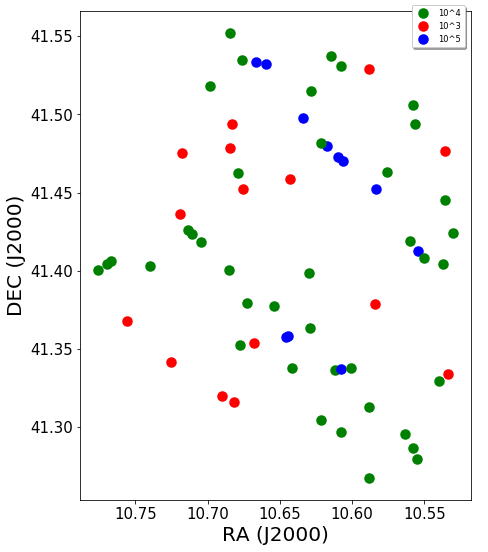

In [45]:
#plot the fit result
#build the frame of the graph
fig, ax = plt.subplots(figsize=(7,9))
#plt.xlim(10,1000)
#plt.ylim(10,200000)
#plt.yscale('log')
#ax.set_xscale('log')

ax.set_xlabel("RA (J2000)")
ax.set_ylabel("DEC (J2000)")
ax.invert_xaxis()

#plot the data and function
for i in range(len(mass_sec)):
    if mass_sec[i]<10000.:
        ax.plot(x[i],y[i],'r.',mew=2,markersize=17.,label='10^3')
    elif mass_sec[i]<100000.:
        ax.plot(x[i],y[i],'g.',mew=2,markersize=17.,label='10^4')
    else:
        ax.plot(x[i],y[i],'b.',mew=2,markersize=17.,label='10^5')

legend = fig.legend(bbox_to_anchor=(0.93, 0.85), shadow=True, fontsize='small')

plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=20)

#plt.savefig('/Users/shjiao/desktop/check/mass_vs_td.pdf')

In [71]:
import aplpy

Mass distribution

INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -1.373e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.370e+00 [aplpy.core]


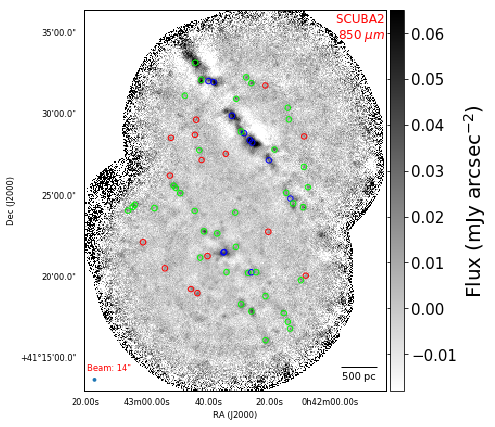

In [75]:
f_850 = aplpy.FITSFigure('/Users/shjiao/desktop/check/m31_850/m31_850.conv.fits', figsize=(7,7))
f_850.show_grayscale()
f_850.add_colorbar()
f_850.colorbar.show()
f_850.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_850.colorbar.set_location('right')
f_850.colorbar.set_axis_label_text(r'Flux (mJy arcsec$^{-2}$)')
f_850.add_label(0.92,0.95, 'SCUBA2 \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_850.show_colorscale(vmin=-0.006*3,vmax=0.065,cmap='gist_yarg',stretch='linear')
f_850.add_beam(major=14.*u.arcsecond,minor=14.*u.arcsecond,angle=0.0)
f_850.add_label(0.085, 0.06, 'Beam: 14\"', relative=True, size='small', layer='title',color='red')
f_850.tick_labels.set_font(size='small')
f_850.axis_labels.set_font(size='small')
f_850.add_scalebar(0.0367281,"500 pc",color='black', corner='bottom right')
for i in range(len(mass_sec)):
    if mass_sec[i]<10000.:
        f_850.show_markers(x[i],y[i],edgecolor='red')
    elif mass_sec[i]<100000.:
        f_850.show_markers(x[i],y[i],edgecolor='lime')
    else:
        f_850.show_markers(x[i],y[i],edgecolor='blue')


Temperature distribution

INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -1.373e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.370e+00 [aplpy.core]


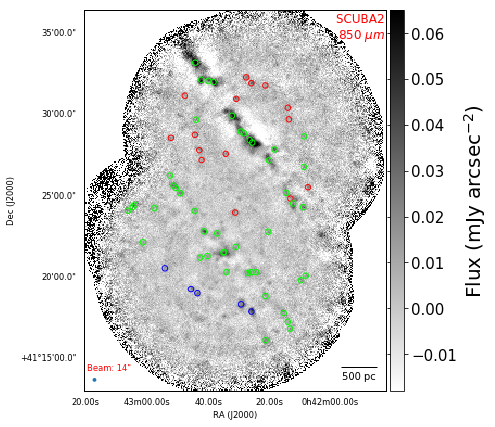

In [80]:
f_850 = aplpy.FITSFigure('/Users/shjiao/desktop/check/m31_850/m31_850.conv.fits', figsize=(7,7))
f_850.show_grayscale()
f_850.add_colorbar()
f_850.colorbar.show()
f_850.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_850.colorbar.set_location('right')
f_850.colorbar.set_axis_label_text(r'Flux (mJy arcsec$^{-2}$)')
f_850.add_label(0.92,0.95, 'SCUBA2 \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_850.show_colorscale(vmin=-0.006*3,vmax=0.065,cmap='gist_yarg',stretch='linear')
f_850.add_beam(major=14.*u.arcsecond,minor=14.*u.arcsecond,angle=0.0)
f_850.add_label(0.085, 0.06, 'Beam: 14\"', relative=True, size='small', layer='title',color='red')
f_850.tick_labels.set_font(size='small')
f_850.axis_labels.set_font(size='small')
f_850.add_scalebar(0.0367281,"500 pc",color='black', corner='bottom right')
for i in range(len(mass_sec)):
    if td[i]<16.5:
        f_850.show_markers(x[i],y[i],edgecolor='red')
    elif td[i]<22.:
        f_850.show_markers(x[i],y[i],edgecolor='lime')
    else:
        f_850.show_markers(x[i],y[i],edgecolor='blue')


extract these outer arm point sources 

INFO: Auto-setting vmin to -5.439e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.636e+01 [aplpy.core]
INFO: Auto-setting vmin to -5.439e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.636e+01 [aplpy.core]


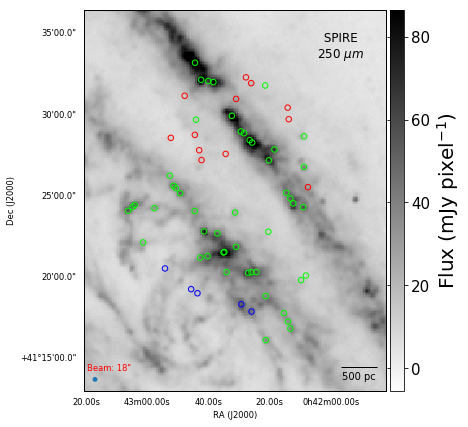

In [87]:
f_250 = aplpy.FITSFigure('/Users/shjiao/desktop/M31/plot/spire250.conv_cutad.fits', figsize=(7,7))
f_250.show_grayscale()
f_250.add_colorbar()
f_250.colorbar.show()
f_250.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_250.colorbar.set_location('right')
f_250.colorbar.set_axis_label_text(r'Flux (mJy pixel$^{-1}$)')
f_250.add_label(0.85,0.9, ' SPIRE \n250 $\mu m$', color='black', relative=True, size='large',layer='source')
f_250.show_colorscale(cmap='gist_yarg')
f_250.add_beam(major=18.*u.arcsecond,minor=18.*u.arcsecond,angle=0.0)
f_250.add_label(0.085, 0.06, 'Beam: 18\"', relative=True, size='small', layer='title',color='red')
f_250.tick_labels.set_font(size='small')
f_250.axis_labels.set_font(size='small')
f_250.add_scalebar(0.0367281,"500 pc",color='black', corner='bottom right')
for i in range(len(mass_sec)):
    if td[i]<16.2:
        f_250.show_markers(x[i],y[i],edgecolor='red')
    elif td[i]<22.:
        f_250.show_markers(x[i],y[i],edgecolor='lime')
    else:
        f_250.show_markers(x[i],y[i],edgecolor='blue')


In [88]:
td_outarm=[]
mass_outarm=[]
nh2_outarm=[]
x_outarm=[]
y_outarm=[]

for i in range(len(mass_sec)):
    if td[i]<16.2:
        td_outarm.append(td[i])
        mass_outarm.append(mass_sec[i])
        nh2_outarm.append(nh2[i])
        x_outarm.append(x[i])
        y_outarm.append(y[i])

In [92]:
print x
print y

[10.588366646584335, 10.554883129580778, 10.5580071157041, 10.563569660786721, 10.607720959360764, 10.62163089817941, 10.588396214514974, 10.681452308606998, 10.690075606626978, 10.540033888439535, 10.53340913129928, 10.612135302395549, 10.607763577502404, 10.601132352022443, 10.641666666700001, 10.725731007913705, 10.644655411666784, 10.677623155631368, 10.667614817996112, 10.645847029735805, 10.628914252700259, 10.755691468192977, 10.654251516623756, 10.672552999190383, 10.584523339569252, 10.629899775250196, 10.685115185666202, 10.776121714213835, 10.7698310663312, 10.74003605365125, 10.554380850896994, 10.767072192348239, 10.550535791491185, 10.536975037216774, 10.560028601662982, 10.704941902896183, 10.710969089221614, 10.713959003709249, 10.53032728512958, 10.719028891069767, 10.583671822018106, 10.535802776696814, 10.675745345312892, 10.678882090517956, 10.642734138544123, 10.617622921859898, 10.576021559186824, 10.609863972973516, 10.606441221231091, 10.717692890095906, 10.5353

In [97]:
y[25],x[25]

(41.398618276429993, 10.629899775250196)

In [100]:
y[24],x[24]

(41.378883640688734, 10.584523339569252)

In [103]:
y[9],x[9]

(41.329207522665747, 10.540033888439535)

In [104]:
y[10],x[10]

(41.333878170528898, 10.53340913129928)

In [105]:
y[53],x[53]

(41.493768877605874, 10.68321223719421)

In [106]:
y[59],x[59]

(41.528809372827311, 10.588486294854674)

In [107]:
y[50],x[50]

(41.476576436278329, 10.535397383558031)

In [109]:
y[41],x[41]

(41.445300270875016, 10.535802776696814)

In [110]:
td_outarm.append(td[25])
mass_outarm.append(mass_sec[25])
nh2_outarm.append(nh2[25])
x_outarm.append(x[25])
y_outarm.append(y[25])

td_outarm.append(td[24])
mass_outarm.append(mass_sec[24])
nh2_outarm.append(nh2[24])
x_outarm.append(x[24])
y_outarm.append(y[24])

td_outarm.append(td[9])
mass_outarm.append(mass_sec[9])
nh2_outarm.append(nh2[9])
x_outarm.append(x[9])
y_outarm.append(y[9])

In [111]:
td_outarm.append(td[10])
mass_outarm.append(mass_sec[10])
nh2_outarm.append(nh2[10])
x_outarm.append(x[10])
y_outarm.append(y[10])

td_outarm.append(td[53])
mass_outarm.append(mass_sec[53])
nh2_outarm.append(nh2[53])
x_outarm.append(x[53])
y_outarm.append(y[53])

td_outarm.append(td[59])
mass_outarm.append(mass_sec[59])
nh2_outarm.append(nh2[59])
x_outarm.append(x[59])
y_outarm.append(y[59])

td_outarm.append(td[50])
mass_outarm.append(mass_sec[50])
nh2_outarm.append(nh2[50])
x_outarm.append(x[50])
y_outarm.append(y[50])

td_outarm.append(td[41])
mass_outarm.append(mass_sec[41])
nh2_outarm.append(nh2[41])
x_outarm.append(x[41])
y_outarm.append(y[41])

INFO: Auto-setting vmin to -5.439e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.636e+01 [aplpy.core]


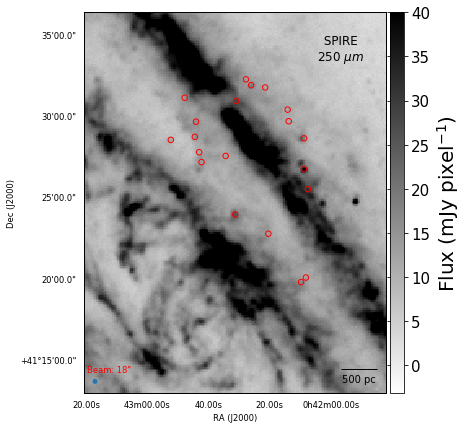

In [123]:
f_250 = aplpy.FITSFigure('/Users/shjiao/desktop/spire250.conv_cutad.fits', figsize=(7,7))
f_250.show_grayscale()
f_250.add_colorbar()
f_250.colorbar.show()
f_250.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_250.colorbar.set_location('right')
f_250.colorbar.set_axis_label_text(r'Flux (mJy pixel$^{-1}$)')
f_250.add_label(0.85,0.9, ' SPIRE \n250 $\mu m$', color='black', relative=True, size='large',layer='source')
f_250.show_colorscale(vmin=-3.1211644,vmax=40.,cmap='gist_yarg')
f_250.add_beam(major=18.*u.arcsecond,minor=18.*u.arcsecond,angle=0.0)
f_250.add_label(0.085, 0.06, 'Beam: 18\"', relative=True, size='small', layer='title',color='red')
f_250.tick_labels.set_font(size='small')
f_250.axis_labels.set_font(size='small')
f_250.add_scalebar(0.0367281,"500 pc",color='black', corner='bottom right')
for i in range(len(mass_outarm)):
    f_250.show_markers(x_outarm[i],y_outarm[i],edgecolor='red')
    

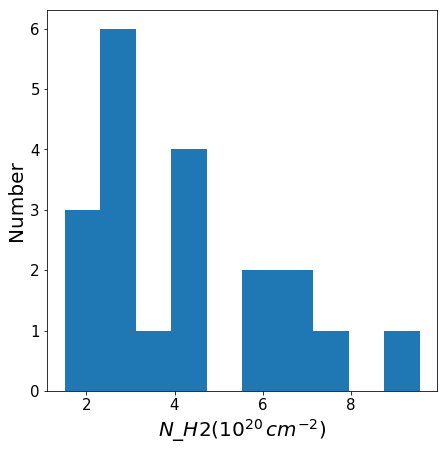

In [114]:
fig=plt.figure(figsize=(7,7))
# the histogram of the data
plt.hist(nh2_outarm,10)

plt.xlabel(r'$N\_H2 (10^{20}\,cm^{-2})$')
plt.ylabel('Number')

plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=20)


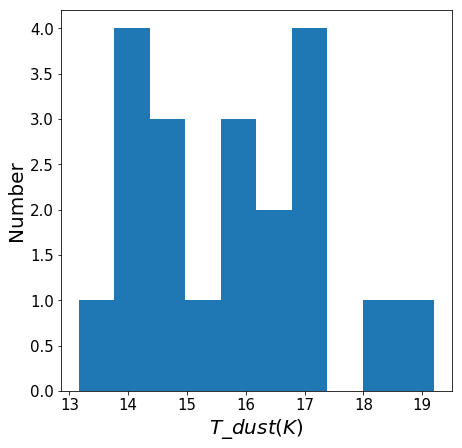

In [115]:
# the histogram of the data
fig=plt.figure(figsize=(7,7))
plt.hist(td_outarm,10)


plt.xlabel(r'$T\_dust (K)$')
plt.ylabel('Number')


plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=25)

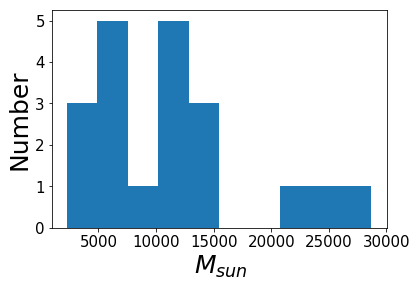

In [116]:
# the histogram of the data
plt.hist(mass_outarm,10)

plt.xlabel(r'$\,M_{sun}$')
plt.ylabel('Number')
plt.show()

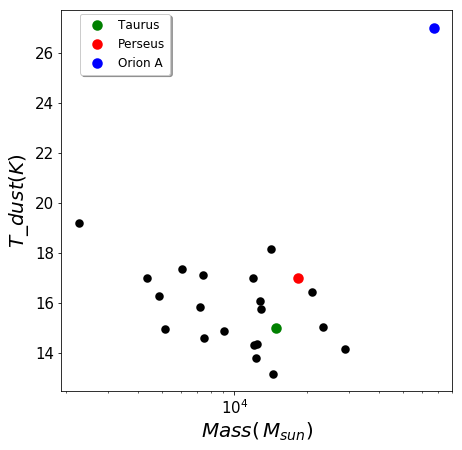

In [120]:
#plot the fit result
#build the frame of the graph
fig, ax = plt.subplots(figsize=(7,7))
#plt.xlim(10,1000)
#plt.ylim(10,200000)
#plt.yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r'$Mass (\,M_{sun})$')
ax.set_ylabel(r'$T\_dust (K)$')


#plot the data and function
ax.plot(mass_outarm,td_outarm,'k.',mew=2,markersize=13.)
ax.plot(14964,15,'g.',mew=2,markersize=17.,label='Taurus')
ax.plot(18438,17,'r.',mew=2,markersize=17.,label='Perseus')
ax.plot(67714,27,'b.',mew=2,markersize=17.,label='Orion A')
legend = fig.legend(bbox_to_anchor=(0.350, 0.877), shadow=True, fontsize='large')

plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=20)

INFO: Auto-setting vmin to  1.775e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.566e+01 [aplpy.core]
INFO: Auto-setting vmin to  1.775e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.566e+01 [aplpy.core]


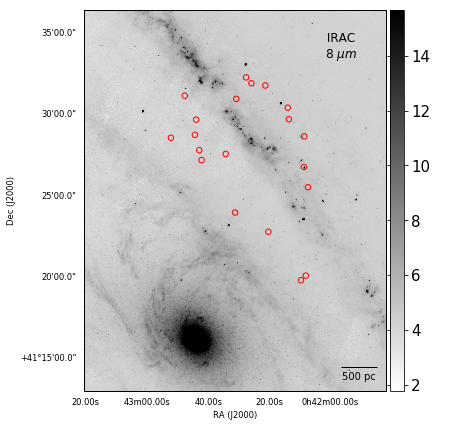

In [121]:
f_8 = aplpy.FITSFigure('/Users/shjiao/desktop/50072571.50072571-54.IRAC.4.mosaic.fits', figsize=(7,7))
f_8.show_grayscale()
f_8.add_colorbar()
f_8.colorbar.show()
f_8.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_8.colorbar.set_location('right')
#f_8.colorbar.set_axis_label_text(r'Flux (mJy pixel$^{-1}$)')
f_8.add_label(0.85,0.9, ' IRAC \n8 $\mu m$', color='black', relative=True, size='large',layer='source')
f_8.show_colorscale(cmap='gist_yarg')
#f_8.add_beam(major=18.*u.arcsecond,minor=18.*u.arcsecond,angle=0.0)
#f_8.add_label(0.085, 0.06, 'Beam: 18\"', relative=True, size='small', layer='title',color='red')
f_8.tick_labels.set_font(size='small')
f_8.axis_labels.set_font(size='small')
f_8.add_scalebar(0.0367281,"500 pc",color='black', corner='bottom right')
for i in range(len(mass_outarm)):
    f_8.show_markers(x_outarm[i],y_outarm[i],edgecolor='red')
    

INFO: Auto-setting vmin to -3.197e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.484e+01 [aplpy.core]


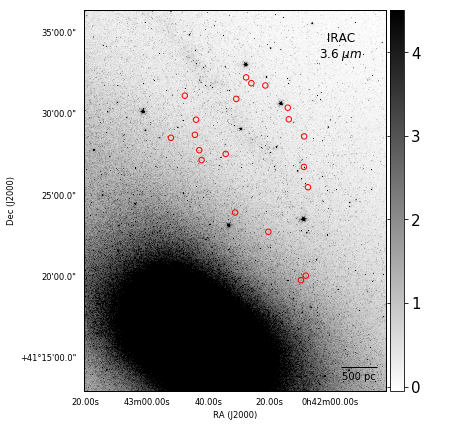

In [125]:
f_3 = aplpy.FITSFigure('/Users/shjiao/desktop/50072571.50072571-54.IRAC.1.mosaic.fits', figsize=(7,7))
f_3.show_grayscale()
f_3.add_colorbar()
f_3.colorbar.show()
f_3.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_3.colorbar.set_location('right')
#f_8.colorbar.set_axis_label_text(r'Flux (mJy pixel$^{-1}$)')
f_3.add_label(0.85,0.9, ' IRAC \n3.6 $\mu m$', color='black', relative=True, size='large',layer='source')
f_3.show_colorscale(vmin=-0.05,vmax=4.5,cmap='gist_yarg')
#f_8.add_beam(major=18.*u.arcsecond,minor=18.*u.arcsecond,angle=0.0)
#f_8.add_label(0.085, 0.06, 'Beam: 18\"', relative=True, size='small', layer='title',color='red')
f_3.tick_labels.set_font(size='small')
f_3.axis_labels.set_font(size='small')
f_3.add_scalebar(0.0367281,"500 pc",color='black', corner='bottom right')
for i in range(len(mass_outarm)):
    f_3.show_markers(x_outarm[i],y_outarm[i],edgecolor='red')
    